## Pauli Measurement

In this notebook, we will explore how to reduce the number of meausrement settings in VQE, which is the major bottleneck when scaling the hybrid QCFD solver to large scales.

### Generate Hamiltonian

In [11]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

Lx = 1              # length of domian in x-direction
Ly = 1              # length of domian in y-direction
nx = 4              # grid size in x-direction
ny = 4              # grid size in y-direction

Re = 100            # Reynolds number
nu = 1/Re           # kinematic viscosity
rho = 1.0           # density
dt =  1             # time step size
itr = 2             # iterations
velocity = 1.0

# Create staggered grid index system
imin, jmin = 1, 1
imax = imin + nx - 1
jmax = jmin + ny - 1

# Define ghost cells for boundary conditions
x = np.zeros(jmax + 2)
y = np.zeros(jmax + 2)
x[imin: imax + 2] = np.linspace(0, Lx, nx + 1, endpoint=True)
y[jmin: jmax + 2] = np.linspace(0, Ly, ny + 1, endpoint=True)

dx = x[imin + 1] - x[imin]
dy = y[jmin + 1] - y[jmin]
dxi = 1 / dx
dyi = 1 / dy

# Define Laplacian
def Laplacian(nx, ny, dxi, dyi):
    Dx = np.diag(np.ones(nx)) * 2 - np.diag(np.ones(nx - 1), 1) - np.diag(np.ones(nx - 1), -1)
    Dx[0, 0] = 1
    Dx[-1, -1] = 1
    Ix = np.diag(np.ones(ny))
    Dy = np.diag(np.ones(ny)) * 2 - np.diag(np.ones(ny - 1), 1) - np.diag(np.ones(ny - 1), -1)
    Dy[0, 0] = 1
    Dy[-1, -1] = 1
    Iy = np.diag(np.ones(nx))
    L = np.kron(Ix, Dx) * dxi ** 2 + np.kron(Dy, Iy) * dyi ** 2
    return L

L = Laplacian(nx, ny, dxi, dyi)
L[0,:]=0
L[0,0]=1


# Variable declaration
u = np.zeros((imax + 2, jmax + 2))
v = np.zeros((imax + 2, jmax + 2))

res_hist_classical = []
for timestep in tqdm(range(itr)):
    
    # u-momentum
    us = u.copy()
    u_old = u.copy()
    I = slice(imin + 1, imax + 1)
    Ib = slice(imin, imax)
    If = slice(imin + 2, imax + 2)
    J = slice(jmin, jmax + 1)
    Jb = slice(jmin - 1, jmax)
    Jf = slice(jmin + 1, jmax + 2)

    v_here = 0.25 * (v[Ib, J] + v[Ib, Jf] + v[I, J] + v[I, Jf])
    us[I, J] = u[I, J] + dt * (
            nu * (u[Ib, J] - 2 * u[I, J] + u[If, J]) * dxi ** 2
            + nu * (u[I, Jb] - 2 * u[I, J] + u[I, Jf]) * dyi ** 2
            - v_here * (u[I, Jf] - u[I, Jb]) * 0.5 * dyi
            - u[I, J] * (u[If, J] - u[Ib, J]) * 0.5 * dxi
    )


    # v-momentum
    vs = v.copy()
    v_old = v.copy()
    I = slice(imin, imax + 1)
    Ib = slice(imin - 1, imax)
    If = slice(imin + 1, imax + 2)
    J = slice(jmin + 1, jmax + 1)
    Jb = slice(jmin, jmax)
    Jf = slice(jmin + 2, jmax + 2)

    u_here = 0.25 * (u[I, Jb] + u[I, J] + u[If, Jb] + u[If, J])
    vs[I, J] = v[I, J] + dt * (
            nu * (v[Ib, J] - 2 * v[I, J] + v[If, J]) * dxi ** 2
            + nu * (v[I, Jb] - 2 * v[I, J] + v[I, Jf]) * dyi ** 2
            - u_here * (v[If, J] - v[Ib, J]) * 0.5 * dxi
            - v[I, J] * (v[I, Jf] - v[I, Jb]) * 0.5 * dyi
    )


    # Claculate R.H.S of pressure Poisson
    Rn = -rho / dt * ((us[imin + 1: imax + 2, jmin: jmax + 1]
                       - us[imin: imax + 1, jmin: jmax + 1]) * dxi
                      + (vs[imin: imax + 1, jmin + 1: jmax + 2]
                       - vs[imin: imax + 1, jmin: jmax + 1]) * dyi)
    
    R = Rn.T.ravel()
    
    # Prepare linear system for VQE
    pv = np.linalg.solve(L, R)

    pn = pv.reshape(ny, nx).T
    p = np.zeros((imax + 1, jmax + 1))
    p[1:, 1:] = pn
    p[0, 0] = 0


    # Correct velocity
    u[imin + 1: imax + 1, jmin: jmax + 1] = us[imin + 1: imax + 1, jmin: jmax + 1] - dt / rho * (
                p[imin + 1: imax + 1, jmin: jmax + 1] - p[imin: imax, jmin: jmax + 1]) * dxi
    v[imin: imax + 1, jmin + 1: jmax + 1] = vs[imin: imax + 1, jmin + 1: jmax + 1] - dt / rho * (
                p[imin: imax + 1, jmin + 1: jmax + 1] - p[imin: imax + 1, jmin: jmax]) * dyi
    
    # Update BCs
    v[imin,:] = 0.0                   # left wall
    v[imax+1,:] = 0.0                 # right wall
    v[:, jmin-1] = -v[:, jmin]        # bottom wall
    v[:, jmax+1] = -v[:, jmax]        # top wall

    u[imin-1, :] = -u[imin, :]        # left wall
    u[imax+1, :] = -u[imax, :]        # right wall
    u[:,imin] = 0                     # bottom wall
    u[:,imax+1] = velocity            # top wall
    
    # Find maximum residual in the domain
    v_res = np.abs(v - v_old)
    u_res = np.abs(u - u_old)
    max_res_u = np.max(u_res)
    max_res_v = np.max(v_res)
    max_res = max(max_res_u, max_res_v)
    res_hist_classical.append(max_res)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2432.89it/s]


Final Iteration = 2; Residual = 0.08428571428571427


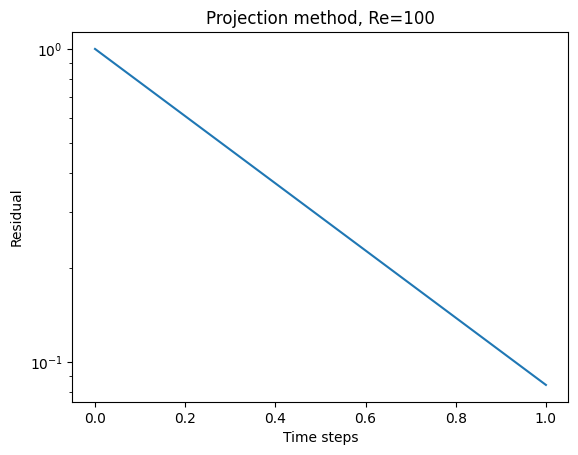

In [12]:
# Final residual        
print(f"Final Iteration = {itr}; Residual = {max_res}")
plt.plot(np.arange(itr), res_hist_classical)
plt.xlabel("Time steps")
plt.ylabel("Residual")
plt.title("Projection method, Re=100")
# plt.grid()
ax = plt.gca()
ax.set_yscale("log")

In [13]:
# Solve x here 
b = R/np.linalg.norm(R)
x = np.linalg.solve(L, b)
x_norm = np.linalg.norm(x)
x_normalized = x/np.linalg.norm(x)

In [14]:
from qiskit.quantum_info.operators import Operator, SparsePauliOp
from qiskit.quantum_info import Pauli

N = 4        # number of qubits
dim = 2**N   # dimension of the operator 
b = b.reshape([dim, 1])
H_test = L.conj().T@(np.eye(dim)- b@b.T)@L
H = SparsePauliOp.from_operator(Operator(H_test))
print(H)

SparsePauliOp(['IIII', 'IIIX', 'IIIZ', 'IIXI', 'IIXX', 'IIYY', 'IIZI', 'IIZX', 'IIZZ', 'IXII', 'IXIX', 'IXIZ', 'IXXI', 'IXXX', 'IXYY', 'IXZI', 'IXZX', 'IXZZ', 'IYIY', 'IYYZ', 'IZII', 'IZIZ', 'IZXI', 'IZXX', 'IZYY', 'IZZI', 'IZZX', 'IZZZ', 'XIII', 'XXII', 'XXIX', 'XXXX', 'XXYY', 'XXZZ', 'YYII', 'YYIX', 'YYXX', 'YYYY', 'YYZZ', 'ZIII', 'ZIIZ', 'ZIXI', 'ZIXX', 'ZIYY', 'ZIZI', 'ZIZX', 'ZIZZ', 'ZXIZ', 'ZXXI', 'ZXXX', 'ZXYY', 'ZXZI', 'ZXZX', 'ZYIY', 'ZYYZ', 'ZYZY', 'ZZII', 'ZZIX', 'ZZIZ', 'ZZXI', 'ZZXX', 'ZZYY', 'ZZZI', 'ZZZX', 'ZZZZ'],
              coeffs=[ 3.0080625e+03+0.j, -1.4080000e+03+0.j, -6.3937500e+01+0.j,
  1.9200000e+02+0.j, -8.0000000e+02+0.j, -9.6000000e+02+0.j,
 -9.5937500e+01+0.j,  6.4000000e+01+0.j, -1.0239375e+03+0.j,
 -1.4080000e+03+0.j,  4.4800000e+02+0.j,  6.4000000e+01+0.j,
  3.2000000e+01+0.j,  1.9200000e+02+0.j,  3.2000000e+02-0.j,
  6.4000000e+01+0.j, -3.2000000e+01+0.j,  3.8400000e+02+0.j,
 -3.2000000e+01+0.j, -3.2000000e+01+0.j,  6.2500000e-02+0.j,
 -3.1937500e+01+

### Visualize Pauli strings

In [20]:
def plot_Ham_paulivec(H, title="", figsize=None, color=None, ax=None, *, filename=None):

    labels = H.paulis
    values = abs(H.coeffs)
    numelem = len(values)

    if figsize is None:
        figsize = (7, 5)
    if color is None:
        color = "#648fff"

    ind = np.arange(numelem)  # the x locations for the groups
    width = 0.5               # the width of the bars
    if ax is None:
        return_fig = True
        fig, ax = plt.subplots(figsize=figsize)
    else:
        return_fig = False
        fig = ax.get_figure()
    ax.grid(zorder=0, linewidth=1, linestyle="--")
    ax.bar(ind, values, width, color=color, zorder=2)
    ax.axhline(linewidth=1, color="k")
    # add some text for labels, title, and axes ticks
    ax.set_ylabel("|Coefficients|", fontsize=14)
    ax.set_xticks(ind)
    ax.set_xticklabels(labels, fontsize=14, rotation=70)
    ax.set_facecolor("#eeeeee")
    for tick in ax.xaxis.get_major_ticks() + ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(14)
    ax.set_title(title, fontsize=16)

In [21]:
sorted_indices = np.argsort(-abs(H.coeffs))
H_sorted = H.copy()
H_sorted = H_sorted[sorted_indices]

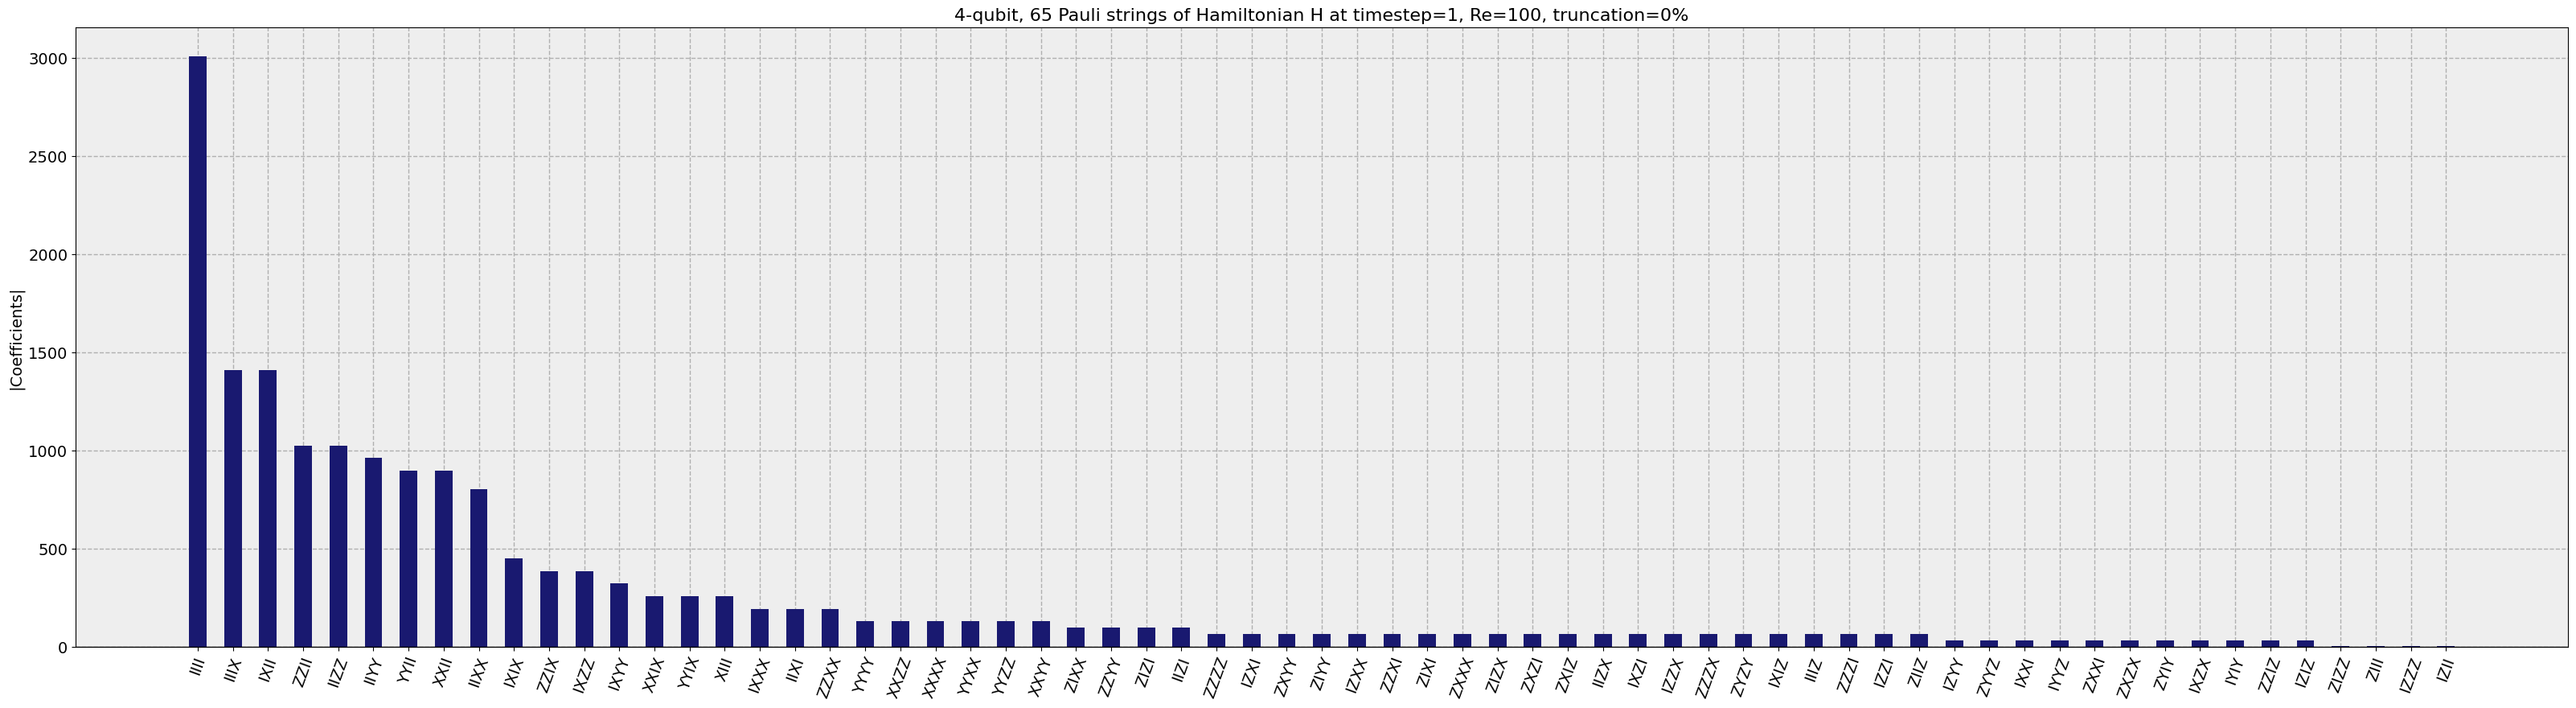

In [22]:
plot_Ham_paulivec(H_sorted, figsize=(40,10), color='midnightblue', 
                  title="4-qubit, 65 Pauli strings of Hamiltonian H at timestep=1, Re=100, truncation=0%")

## commutativity based measurement reduction

Qiskit supports two measurement resucetion methods based on

> Gokhale, Pranav, et al. "Optimization of simultaneous measurement for variational quantum eigensolver applications." 2020 IEEE International Conference on Quantum Computing and Engineering (QCE). IEEE, 2020.

In [28]:
H_qwc = H.group_commuting(qubit_wise=True)
print("Number of measurement groups using qubit-wise commutativity (QWC):", len(H_qwc))

Number of measurement groups using qubit-wise commutativity (QWC): 16


In [29]:
H_gc = H.group_commuting(qubit_wise=False)
print("Number of measurement groups using group commutativity (GC):", len(H_gc))

Number of measurement groups using group commutativity (GC): 10


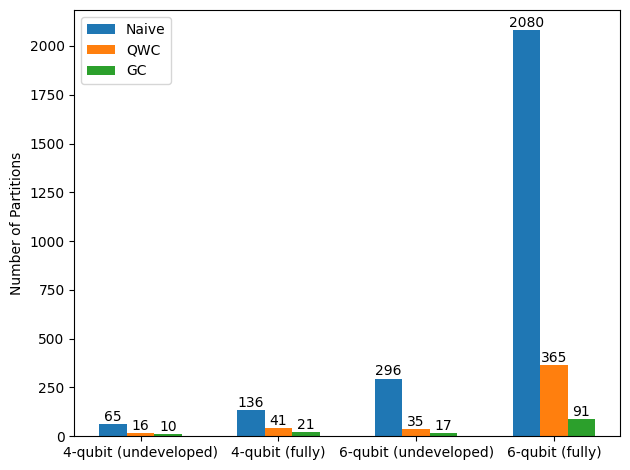

In [32]:
import numpy as np
import matplotlib.pyplot as plt

N = [4,4,6,6,8]
n_original_paulis = [65, 136, 296, 2080, 32896]
n_qwc_paulis = [16, 41, 35, 365, 3281]
n_gc_paulis = [10, 21, 17, 91, 381]

# Number of groups and data points
num_groups = 4
num_data_points = 3

# Generate some random data for the plot
data = np.array([[65, 16, 10], [136, 41, 21], [296, 35, 17], [2080, 365, 91]])

# Define the x locations for the groups
x = np.arange(num_groups)

# Width of each bar
bar_width = 0.2

color_list = ["#635EC2", "#C65CB6", "#FF6997"]
label_list = ["Naive", "QWC", "GC"]

# Create the bar plot
for i in range(num_data_points):
    bars = plt.bar(x + i * bar_width, data[:, i], width=bar_width, label=label_list[i])
    
    # Add numbers above the bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f'{height:.0f}', ha='center', va='bottom')


# Add labels and title
plt.ylabel('Number of Partitions')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(x + bar_width * (num_data_points - 1) / 2, ["4-qubit (undeveloped)", "4-qubit (fully)", "6-qubit (undeveloped)", "6-qubit (fully)"])
plt.legend()

# Show the plot
plt.tight_layout()
# plt.savefig("pauli-scaling.png", dpi=300)

## Non-Pauli basis decompostion

Under development.

## Software info

In [33]:
import qiskit
import qiskit_ibm_runtime

print(f'Qiskit: {qiskit.__version__}')
print(f'Qiskit IBM Runtime: {qiskit_ibm_runtime.__version__}')

Qiskit: 1.0.2
Qiskit IBM Runtime: 0.23.0
